In [1]:
%matplotlib inline

In [331]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette('Blues')

In [141]:
def regrid(variable,nlon,nlat):
    assert isinstance(variable,xr.DataArray),"please pass a xarray DataArray not whole dataset"
    lat_gpd=variable.groupby_bins('lat',np.arange(-90,91,float(180.0)/nlat))
    latreg=lat_gpd.mean(dim='lat')
    lon_gpd=latreg.groupby_bins('lon',np.arange(-180,180,float(180.0)/nlon))
    regrided=lon_gpd.mean(dim='lon')
    regrided=regrided.rename({'lat_bins':'lat','lon_bins':'lon'})
    lats=[]
    for latbin in regrided.lat.values:
        latbounds=[float(lat) for lat in str(latbin).strip(r'(])').split(',')]
        lats.append(np.mean(latbounds))
    lons=[]
    for lonbin in regrided.lon.values:
        lonbounds=[float(lon) for lon in str(lonbin).strip(r'(])').split(',')]
        lons.append(np.mean(lonbounds))
    regrided['lon']=lons
    regrided['lat']=lats
    return regrided
def subgrid(variable,nlon,nlat):
    assert isinstance(variable,xr.DataArray),"please pass a xarray DataArray not whole dataset"
    lat_gpd=variable.groupby_bins('lat',np.arange(-90,91,float(180.0)/nlat))
    latreg=lat_gpd.apply(lambda x:x-x.mean(dim='lat'))
    lon_gpd=latreg.groupby_bins('lon',np.arange(-180,180,float(180.0)/nlon))
    subgrided=lon_gpd.apply(lambda x:x-x.mean(dim='lon'))
    return subgrided
def transect(variable,lonmin=0,lonmax=0,latmin=0,latmax=0):
    assert isinstance(variable,xr.DataArray),"please pass a xarray DataArray not whole dataset"
    if latmin==0 and latmax==0 and lonmin==0 and lonmax==0:
        latmin=min(variable.lat.values)
        latmax=max(variable.lat.values)
        lonmin=min(variable.lon.values)
        lonmax=max(variable.lon.values)
    lons=variable.lon.sel(lon=slice(lonmin,lonmax))
    lats=variable.lat.sel(lat=slice(latmin,latmax))
    lons=[lon for lon,lat in zip(lons,lats)]
    lats=[lat for lon,lat in zip(lons,lats)]
    transect=variable.sel_points(method='nearest',lat=lats,lon=lons)
    return transect.T

In [186]:
g5nr7km_3Ddataset=xr.open_dataset('http://weather.rsmas.miami.edu/repository/opendap/synth:1142722f-a386-4c17-a4f6-0f685cd19ae3:L0c1TlIvR0VPUzUtTmF0dXJlLVJ1bi1JbnN0MzBtaW4tN2ttX3ByZXNzdXJlX21ldGhvZDIubmNtbA==/entry.das')
g5nr7km_2Ddataset=xr.open_dataset('http://opendap.nccs.nasa.gov:9090/dods/OSSE/G5NR/Ganymed/7km/0.0625_deg/inst/inst30mn_2d_met1_Nx')

In [196]:
dates=pd.date_range('2005-07-06 21:30:00', periods=4,freq='30min')
sample3D=g5nr7km_3Ddataset.sel(time=dates,lat=slice(17,23),lon=slice(76,84))
sample2D=g5nr7km_2Ddataset.sel(time=dates,lat=slice(17,23),lon=slice(76,84))

In [224]:
sample3D.data_vars

Data variables:
    cloud    (time, lev, lat, lon) float64 ...
    qi       (time, lev, lat, lon) float64 ...
    ql       (time, lev, lat, lon) float64 ...
    qr       (time, lev, lat, lon) float64 ...
    qs       (time, lev, lat, lon) float64 ...
    qv       (time, lev, lat, lon) float64 ...
    taucli   (time, lev, lat, lon) float64 ...
    tauclw   (time, lev, lat, lon) float64 ...
    tauir    (time, lev, lat, lon) float64 ...
    t        (time, lev, lat, lon) float64 ...
    u        (time, lev, lat, lon) float64 ...
    v        (time, lev, lat, lon) float64 ...
    w        (time, lev, lat, lon) float64 ...
    epv      (time, lev, lat, lon) float64 ...
    airdens  (time, lev, lat, lon) float64 ...

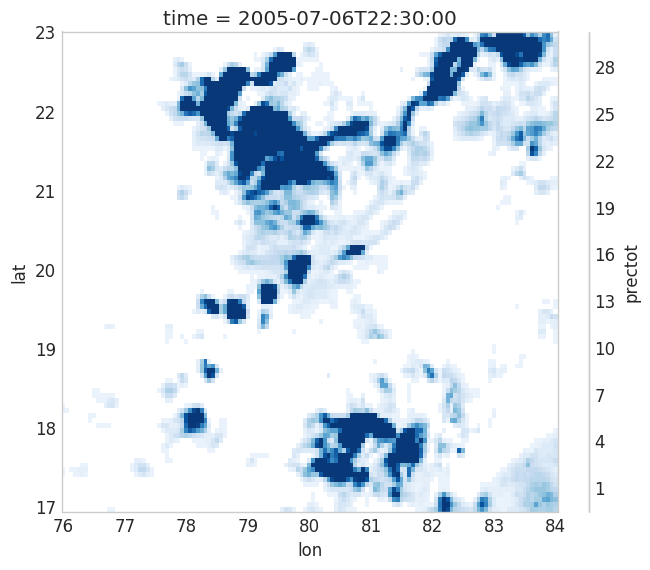

In [332]:
prectot=sample2D.prectot[2,:,:]*86400
p=prec.prectot.plot.pcolormesh(levels=np.arange(1,30,1),cmap='Blues')
p.cmap.set_under('white')

In [223]:
up=subgrid(sample3D['u'],90,45)
vp=subgrid(sample3D['v'],90,45)
wp=subgrid(sample3D['w'],90,45)

In [227]:
upwp=up*wp
vuwp=vp*wp

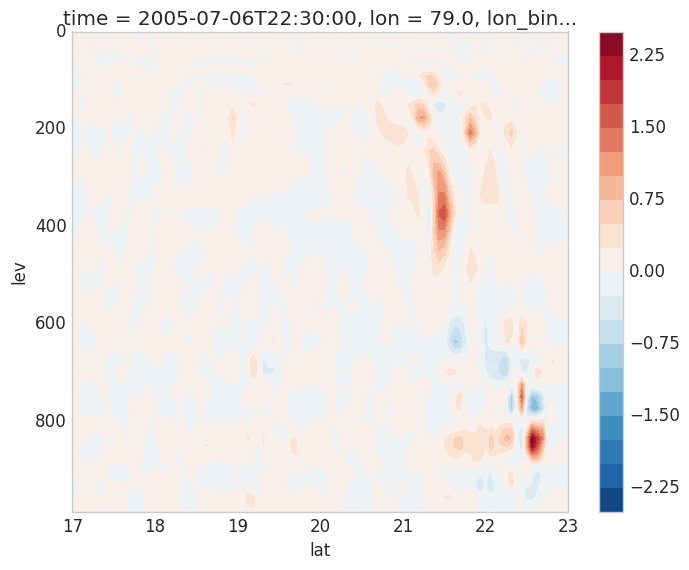

In [238]:
upwp[2,:,:,:].sel(lon=79).plot.contourf(yincrease=False,levels=20)

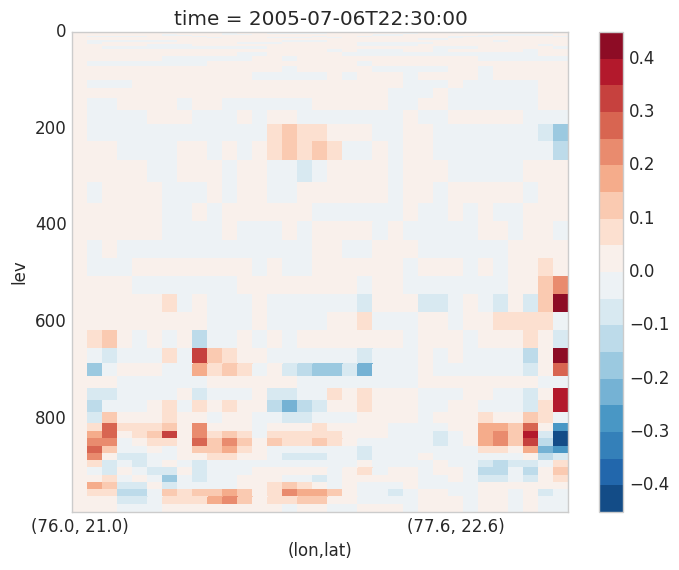

In [237]:
crossection=transect(upwp,latmin=21,latmax=23,lonmin=76,lonmax=83)
f,ax=plt.subplots(1,1)
crossection[:,2,:].plot.pcolormesh(yincrease=False,ax=ax,levels=20)
lonlattics=[repr((round(lon,1),round(lat,1)))for lat,lon in zip(crossection.lat.values,crossection.lon.values)]
plt.xticks(crossection.points[::25],lonlattics[::25])
plt.xlabel('(lon,lat)')

In [338]:
uandv=xr.merge([sample3D.u,sample3D.v])

In [341]:
uandvshear=uandv.apply(np.gradient,axis=1) #/np.gradient(uandv.lev*100)

In [369]:
levda=uandv.lev*100.0
levda=levda.to_dataset(name='dp').apply(np.gradient)

In [371]:
uandvshear=uandvshear/levda.dp